In [11]:
import numpy as np
from PIL import Image
from dataclasses import dataclass

screen_x, screen_y = 1920, 1080 
eye_distance = 2
distance_proj_origin = 2

@dataclass
class Vertex:
    xyz: np.ndarray[3]
    distance: int = 0

    @property
    def x(self): return self.xyz[0]
    @property
    def y(self): return self.xyz[1]
    @property
    def z(self): return self.xyz[2]
    def update_distance(self):
        self.distance = np.sqrt(
            self.x * self.x +
            self.y * self.y + 
            (eye_distance + distance_proj_origin + self.z) *
            (eye_distance + distance_proj_origin + self.z)
        )

size_at_unit_1 = 32

def color_lerp(size, min_val=0, max_val=10, output_min=255, output_max=0):
    if size <= min_val:
        return output_min
    elif size >= max_val:
        return output_max
    else:
        return output_min + (output_max - output_min) * ((size - min_val) / (max_val - min_val))

def rasterize(x: int, y: int, color: float, data: np.ndarray):
    if (x < 0 or x >= screen_x) or (y < 0 or y >= screen_y):
        return
    data[-y, x] = color

def draw_vertex_on_screen(x: int, y: int, color: float, distance: int, data: np.ndarray) -> None:
    size = int(size_at_unit_1 / max(distance, 1))  # Avoid division by zero

    # Adjust color based on distance, assuming distance is non-zero
    dimmed_color = color - color_lerp(size)
    
    for dy in range(-size, +size):
        for dx in range(-size, +size):
            r = np.sqrt(dy * dy + dx * dx)
            if r >= size:
                continue
            rasterize(x + dx, y + dy, dimmed_color, data = data)

def draw_vertex(vert: Vertex, data: np.ndarray, log: bool = False) -> tuple[int, int]:

    #                                           (x/y)-axis
    #                                             ^
    #                    screen projection  ___---|
    #                          |      ___---      |
    #                          |___---            |
    #                    ___---|                  | 
    #              ___---      | origin'          |  origin
    #         __---            |/                 | /
    # camera ----------------->|----------------->|-----------> z-axis
    #           eye distance    distance to origin
    #
    # To project from world space to screen space we can scale down 
    # the Vertex coordinates, since two triangles formed camera x-axis
    # and camera - screen projection are congruent.

    k = eye_distance / (eye_distance + distance_proj_origin + vert.z)
    proj_y = vert.y * k
    proj_x = vert.x * k
    
    # Calculate aspect ratio correction factor
    aspect_ratio = screen_y / screen_x

    # Adjust x projection to account for aspect ratio
    proj_x *= aspect_ratio

    # Map normalized coordinates to screen space
    screen_proj_y = int((proj_y + 1) * screen_y / 2.0)
    screen_proj_x = int((proj_x + 1) * screen_x / 2.0)
    vert.update_distance()
    
    if log:
        print("K: ", k)
        print("                    x   y   z")
        print("World position:    ", vert.x, vert.y, vert.z)
        print("Screen projection: ", proj_x, proj_y)
        print("Screen pixels:     ", screen_proj_x, screen_proj_y)
        print("Distance: ", vert.distance)

    draw_vertex_on_screen(screen_proj_x, screen_proj_y, distance = vert.distance, color = 255.0, data = data)


data = np.zeros((screen_y, screen_x))
for vert in [
    Vertex([0.0, 0.0, 0.0]),
    Vertex([-2.0, 1.0, 1.0])
]:
    draw_vertex(vert, data, log = True)

Image.fromarray(data).show()

K:  0.5
                    x   y   z
World position:     0.0 0.0 0.0
Screen projection:  0.0 0.0
Screen pixels:      960 540
Distance:  4.0
K:  0.4
                    x   y   z
World position:     -2.0 1.0 1.0
Screen projection:  -0.45 0.4
Screen pixels:      528 756
Distance:  5.477225575051661


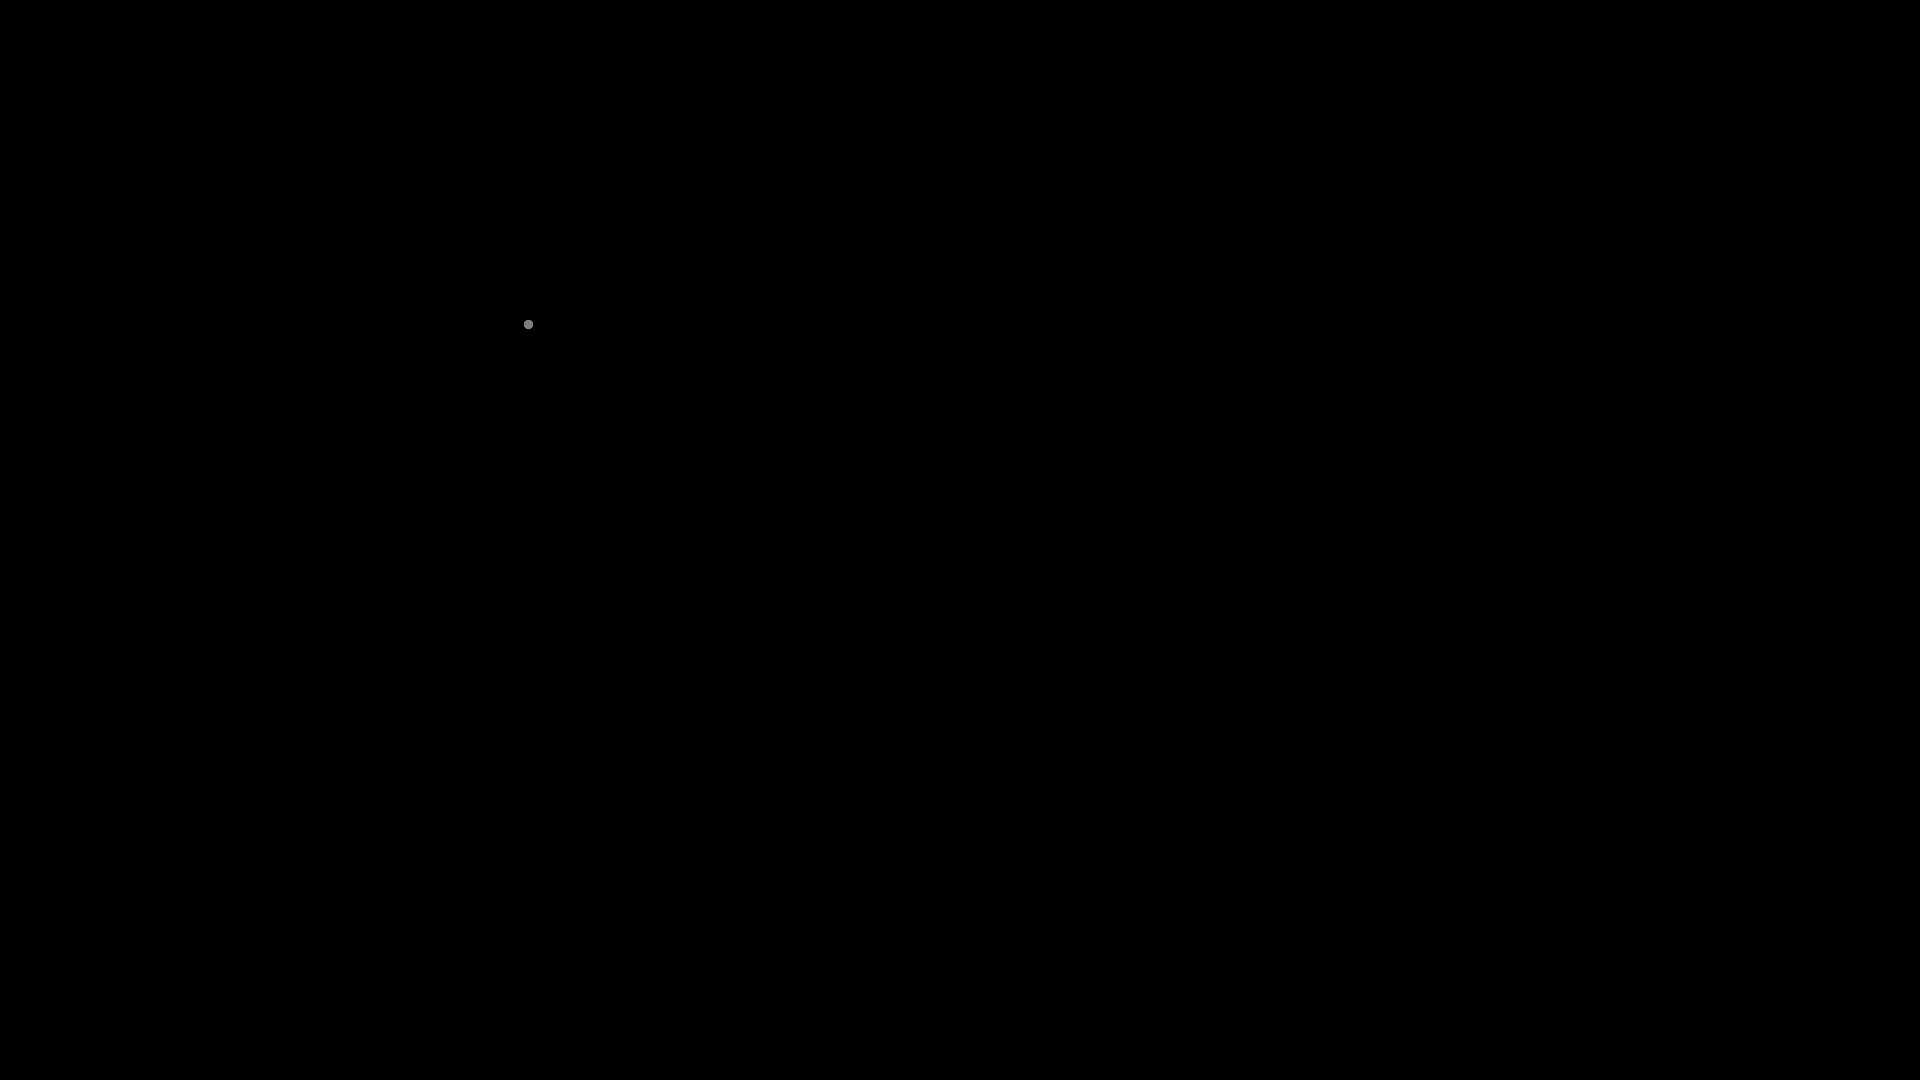

In [12]:
import imageio

frames = imageio.get_writer("point.gif", mode="I")
for t in np.linspace(0, 10, 50):
    pic = np.zeros((screen_y, screen_x))

    v = Vertex([-2.0, 1.0, 1.0 + t])
    draw_vertex(v, pic)
    frames.append_data(pic)
frames.close()

from IPython.display import Image, display
display(Image(filename='point.gif'))

In [13]:
cube_density = 10

cube = np.zeros((screen_y, screen_x))
vertices = []

for z in np.linspace(-1, 1, cube_density):
    for y in np.linspace(-1, 1, cube_density):
        for x in np.linspace(-1, 1, cube_density):
            v = Vertex([x, y, z + 0.5])
            draw_vertex(v, cube)

from PIL import Image
Image.fromarray(cube).show()